In [57]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle competitions download -c credit-card-fraud-prediction

 93% 31.0M/33.4M [00:00<00:00, 74.0MB/s]
100% 33.4M/33.4M [00:00<00:00, 66.0MB/s]


In [59]:
!unzip credit-card-fraud-prediction.zip

Archive:  credit-card-fraud-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [63]:
# Veri setlerini yükle
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [64]:
train.head(2)

,id,Time,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,...,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,Transaction_Amount,IsFraud
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0


In [66]:
train_df['IsFraud'].value_counts()

,count
IsFraud,
0,149731
1,269


In [68]:
# Özellikleri ve hedef değişkeni belirle
X = train.drop(['IsFraud', 'id'], axis=1)  # 'id' ve hedef değişken hariç
y = train['IsFraud']

In [69]:
from imblearn.over_sampling import SMOTE

# SMOTE ile veri dengeleme
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [70]:
# Eğitim ve test setlerine ayır
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Modelleme

In [71]:
# Modeli oluştur ve eğit
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [72]:
# Doğrulama seti üzerinde tahmin yap
y_val_pred = model.predict_proba(X_val)[:, 1]  # Olasılıkları al
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)

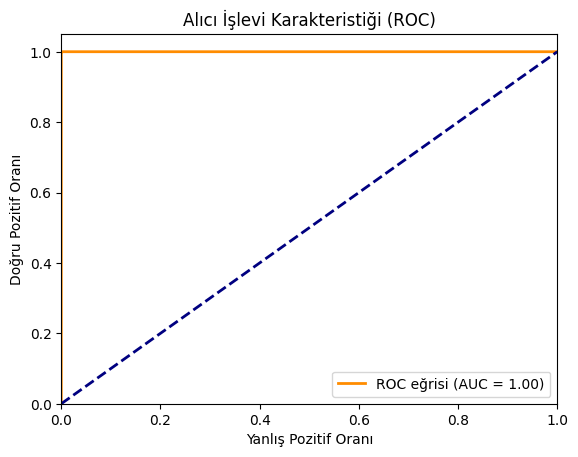

In [73]:
# ROC eğrisini çiz
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC eğrisi (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı')
plt.ylabel('Doğru Pozitif Oranı')
plt.title('Alıcı İşlevi Karakteristiği (ROC)')
plt.legend(loc='lower right')
plt.show()

Test Seti Üzerinde Tahmin Yapma

In [74]:
# Test seti üzerinde tahmin yap
X_test = test.drop(['id'], axis=1)  # 'id' hariç
y_test_pred = model.predict_proba(X_test)[:, 1]

# Sonuçları kaydet
submission['IsFraud'] = y_test_pred
submission.to_csv('submission.csv', index=False)

Diğer Modeller

In [75]:
# @title XGBoost Modeli
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score

# XGBoost modelini oluştur
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Modeli eğit
xgb_model.fit(X_train, y_train)

# Doğrulama seti üzerinde tahmin yap
y_val_pred = xgb_model.predict_proba(X_val)[:, 1]

# Modelin performansını değerlendir
accuracy = accuracy_score(y_val, (y_val_pred > 0.5).astype(int))
roc_auc = roc_auc_score(y_val, y_val_pred)

print(f'XGBoost Doğruluk: {accuracy:.2f}')
print(f'XGBoost ROC AUC: {roc_auc:.2f}')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:59:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Doğruluk: 1.00
XGBoost ROC AUC: 1.00


In [76]:
# @title LightGBM Modeli
import lightgbm as lgb

# LightGBM modelini oluştur
lgb_model = lgb.LGBMClassifier(random_state=42)

# Modeli eğit
lgb_model.fit(X_train, y_train)

# Doğrulama seti üzerinde tahmin yap
y_val_pred = lgb_model.predict_proba(X_val)[:, 1]

# Modelin performansını değerlendir
accuracy = accuracy_score(y_val, (y_val_pred > 0.5).astype(int))
roc_auc = roc_auc_score(y_val, y_val_pred)

print(f'LightGBM Doğruluk: {accuracy:.2f}')
print(f'LightGBM ROC AUC: {roc_auc:.2f}')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 119698, number of negative: 119871
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 239569, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499639 -> initscore=-0.001444
[LightGBM] [Info] Start training from score -0.001444
LightGBM Doğruluk: 0.98
LightGBM ROC AUC: 1.00


In [77]:
# XGBoost ile test seti üzerinde tahmin yap
y_test_pred_xgb = xgb_model.predict_proba(X_test)[:, 1]
submission['IsFraud'] = y_test_pred_xgb
submission.to_csv('submission_xgb.csv', index=False)

# LightGBM ile test seti üzerinde tahmin yap
y_test_pred_lgb = lgb_model.predict_proba(X_test)[:, 1]
submission['IsFraud'] = y_test_pred_lgb
submission.to_csv('submission_lgb.csv', index=False)